In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

df = pd.read_csv('TrainData.csv')
df = df.drop(columns=['ties_away', 'ties_home'])

#Target
df['Diff'] = df['Diff'].apply(lambda x: 20 if x > 20 else x)
df['Diff'] = df['Diff'].apply(lambda x: -20 if x < -20 else x)
y = df['Diff']
# drop strings/unused columns
X = df.drop(columns=['Week', 'Time', 'Away', 'Tm_away', 'Home', 'Tm_home', 'Home_Score', 'Away_Score'])
X = X.drop('Diff', axis=1)


#test
test = pd.read_csv('TestData.csv')
test = test.drop(columns=['ties_away', 'ties_home'])

y_test = test['Diff']
X_test = test.drop(columns=['Diff','Week', 'Time', 'Away', 'Tm_away', 'Home', 'Tm_home', 'Home_Score', 'Away_Score'])
# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train = X
y_train = y
X_test = scaler.transform(X_test)

#layers

normalize = tf.keras.layers.Normalization(axis=-1)
normalize.adapt(np.array(X_train))

model = tf.keras.Sequential([normalize,
        keras.layers.Dropout(0.45),
        keras.layers.Dense(294, activation='tanh'),
        keras.layers.Dense(294, activation='elu',kernel_initializer='ones',kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)),
        keras.layers.Dense(294, activation='elu',kernel_initializer='lecun_normal'),
        keras.layers.Dense(294, activation= 'elu'),
        keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')  # Specify optimizer and loss function

# Train the model
history = model.fit(X_train, y_train, verbose=0, epochs=700, validation_split=0.2)
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Mean Absolute Error on Test Data: {loss}')

/Users/kushal/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-11 19:08:12.957086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Mean Absolute Error on Test Data: 12.102335929870605


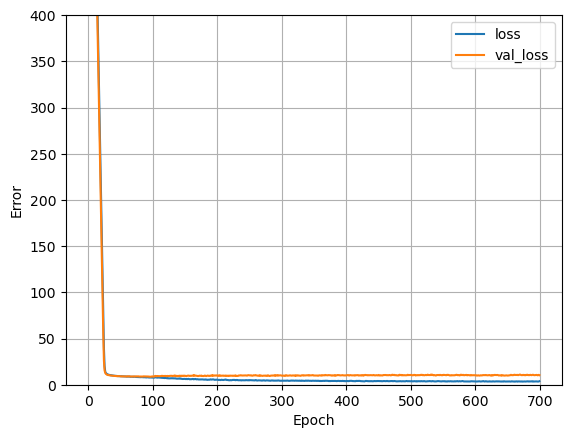

In [8]:

#Analyze loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.ylim(0, 400)  # Set the desired y-axis range

plt.grid(True)


In [85]:
#predict
# Perform predictions on the last 100 elements of the training dataset
test = pd.read_csv('TestData.csv')
test = test.drop(columns=['ties_away', 'ties_home'])

adj = -6
expected = test['Diff']
pred = test.drop(columns=['Diff','Week', 'Time', 'Away', 'Tm_away', 'Home', 'Tm_home', 'Home_Score', 'Away_Score'])
win = total  = spread = 0
#print(expected)
predictions = model.predict(pred)
for i, prediction in enumerate(predictions):
   print(f"Expected: {expected.iloc[i]}, Predicted: {prediction[0]+adj}")
   total+=1
   if (expected.iloc[i] > 0 and prediction[0]+adj > 0) or (expected.iloc[i] < 0 and prediction[0]+adj < 0):
     win+=1
   if (np.abs(expected.iloc[i] - prediction[0]+adj) < 8):
     spread+=1
print(win, "/", total)
print(spread, "/", total)

2/2 [==============================] - 0s 2ms/step
Expected: 21, Predicted: 6.948480606079102
Expected: -21, Predicted: 6.670444488525391
Expected: 20, Predicted: 3.8310728073120117
Expected: -3, Predicted: -15.112342834472656
Expected: -4, Predicted: -7.9715659618377686
Expected: -28, Predicted: -12.818630695343018
Expected: 11, Predicted: -3.2807741165161133
Expected: 1, Predicted: 0.7973418235778809
Expected: -2, Predicted: -5.28326940536499
Expected: 1, Predicted: -2.16195011138916
Expected: 28, Predicted: 4.951350212097168
Expected: -7, Predicted: -7.7760021686553955
Expected: -13, Predicted: -12.847214221954346
Expected: -3, Predicted: -6.250483423471451
Expected: 6, Predicted: 5.423487663269043
Expected: -11, Predicted: 3.5898942947387695
Expected: 5, Predicted: 3.6333484649658203
Expected: -17, Predicted: -14.490286827087402
Expected: -3, Predicted: 5.07669734954834
Expected: -20, Predicted: -16.30312156677246
Expected: 3, Predicted: -8.151993036270142
Expected: 13, Predicted: 

In [118]:
#predict
# Perform predictions on the last 100 elements of the training dataset
#model.save('model.h5')
from tensorflow.keras.models import load_model

# load model 
model = load_model('model.h5')
test = pd.read_csv('2023Test.csv')
test = test.drop(columns=['Week', 'Time', 'Away', 'Tm_away', 'Home', 'Tm_home', 'D2P_Def_away','D2P_Def_home' ])
newCol = {'L_away': 'losses_away', 'L_home': 'losses_home', 'W-L%_away': 'wlp_away',
          'W-L%_home': 'wlp_home', 'W_away': 'wins_away', 'W_home': 'wins_home'}
test = test.rename(columns=newCol)
unique_columns_df1 = test.columns.difference(pred.columns)
unique_columns_df2 = pred.columns.difference(test.columns)
#print("Unique columns in DataFrame 1:")
#print(unique_columns_df1)
shape = test.shape
#print("Shape of the DataFrame:", shape)
#print("\nUnique columns in DataFrame 2:")
#print(unique_columns_df2)
#shape = pred.shape
#print("Shape of the DataFrame:", shape)
pred = test#.drop(columns=['Week', 'Time', 'Away', 'Tm_away', 'Home', 'Tm_home'])
predictions = model.predict(pred)
test = pd.read_csv('2023Test.csv')
count = 0
teams =  test['Home'].unique()

init = {'Name': teams,
        'Wins': [0]*32,
        'Losses': [0]*32}

simulate = pd.DataFrame(init)

for index, row in test.iterrows():
    print(f"{row['Week']} {row['Away']} vs Home: {row['Home']}: {predictions[count]}")
    if (predictions[count] > 0):
        simulate.loc[simulate['Name'] == row['Home'], 'Wins'] += 1
        simulate.loc[simulate['Name'] == row['Away'], 'Losses'] += 1
    else:
        simulate.loc[simulate['Name'] == row['Away'], 'Wins'] += 1
        simulate.loc[simulate['Name'] == row['Home'], 'Losses'] += 1
    count+=1
print(simulate)

ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [None, None], with unknown axis at index: 1

In [119]:
from tensorflow.keras.models import save_model
save_model(model, 'nflfinal')

from tensorflow.keras.models import load_model
loaded_model = load_model('nflfinal')

INFO:tensorflow:Assets written to: nflfinal/assets
